In [1]:
#%pylab inline
import numba, numpy as np, matplotlib.pyplot as plt
from numba import cuda



In [2]:

from pylab import imshow, show
from timeit import default_timer as timer

# mandelbrot example

In [3]:
# from numba import autojit
@numba.jit
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

@numba.jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color

In [4]:
from numba import cuda
from numba import *

mandel_gpu = cuda.jit(device=True)(mandel)

Mandelbrot created in 0.643229 s


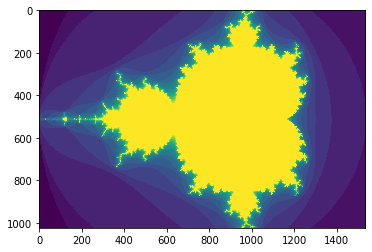

In [5]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 
dt = timer() - start

print("Mandelbrot created in %f s" % dt)
imshow(image)
show()

In [6]:
@cuda.jit
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX, startY = cuda.grid(2)
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel_gpu(real, imag, iters)

In [7]:
gimage = np.zeros((1024, 1536), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_image = cuda.to_device(gimage)
mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, d_image, 20) 
d_image.to_host()
dt = timer() - start

print("Mandelbrot created on GPU in %f s" % dt)
imshow(gimage)
show()

CudaSupportError: Error at driver init: 
[999] Call to cuInit results in CUDA_ERROR_UNKNOWN:

# fail at getting time_step to be gpu accelerated without alteration

In [ ]:
from lib import *
#load the libraries
from lib.operari import *
from lib.ProgressBar import *
from lib.minimal_model import *
from lib.TexturePlot import *
from lib.get_tips import *
from lib.minimal_model import *
from lib.intersection import *

In [ ]:
from numba import cuda
from numba import *

time_step_gpu = cuda.jit(device=True)(time_step_at_pixel)

In [ ]:
#import the time step and use it on an example texture
file = '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ic-out/ic_200x200.001.13.npz'
txt = load_buffer(file)
txt.shape

In [ ]:
time_step_cuda(texture=txt, h=0.025, zero_txt=zero_txt.copy())

In [ ]:
zero_txt = np.zeros_like(txt)
for j in range(500):
    time_step(texture=txt, h=0.025, zero_txt=zero_txt.copy())

In [ ]:
time_step_cuda = cuda.jit(device=True)(time_step)

In [ ]:
@cuda.jit
def get_time_step_kernel(texture, out):
    height = texture.shape[0]
    width = texture.shape[1]

    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;

    for x in range(startX, width, gridX):
        for y in range(startY, height, gridY):
            out[y, x] = np.array(time_step_gpu(inVfs=texture,x=x,y=y))

In [ ]:
1024/32
1536/32

In [ ]:
# # gimage = np.zeros((1024, 1536), dtype = np.uint8)
# gimage = np.zeros((1024, 1536, 3), dtype = np.float32)
# # gimage = txt.copy()
# dtexture_dt = gimage.copy()#zero_txt.copy()

# blockdim = (32, 8)
# griddim = (32,16)

# start = timer()
# d_image = cuda.to_device(gimage)
# d_dtexture_dt = cuda.to_device(dtexture_dt)
# get_time_step_kernel[griddim, blockdim](txt, d_dtexture_dt)
# d_image.to_host()
# dt = timer() - start

# print("Mandelbrot created on GPU in %f s" % dt)
# imshow(gimage)
# show()

# (not working) fast matrix multiplication 
but complicated to understand and isn't being called right

In [ ]:
from numba import cuda, float32

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 16

@cuda.jit
def fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

In [ ]:
A = np.ones((200,200))
B = 2*A.copy()
C = np.zeros_like(A)

In [ ]:
fast_matmul(A, B, C)
C

In [ ]:
@cuda.jit
def matmul(A, B, C):
    """Perform square matrix multiplication of C = A * B
    """
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[i, k] * B[k, j]
        C[i, j] = tmp

In [ ]:
matmul(A, B, C)

In [ ]:
C

# add two matrices the same shape as my texture with float64 percision

In [ ]:
from numba import cuda
# from numba import *

In [ ]:
# from numba import autojit
@numba.jit
def add(a, b):
    return a + b

In [ ]:
foo_gpu = cuda.jit(device=True)(add)

In [ ]:
@cuda.jit
def foo_kernel(image1, image2, out):
    height = image1.shape[0]
    width  = image1.shape[1]

    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;

    for x in range(startX, width, gridX):
        for y in range(startY, height, gridY):
            a = image1[y,x]
            b = image2[y,x]
            out[y, x] = a+b#foo_gpu(a, b)

In [ ]:
gout    = np.zeros((1024, 1536), dtype = np.uint8)
gimage1 = np.ones((1024, 1536), dtype = np.uint8)
gimage2 = np.ones((1024, 1536), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_image1 = cuda.to_device(gimage1)
d_image2 = cuda.to_device(gimage1)
d_out    = cuda.to_device(gout)
foo_kernel[griddim, blockdim](d_image1, d_image2, d_out) 
d_out.to_host()
dt = timer() - start

print("Output created on GPU in %f s" % dt)
imshow(gout)
show()

In [ ]:
gout    = np.zeros((200, 200), dtype = np.float64)
gimage1 = 2*np.ones((200, 200), dtype = np.float64)
gimage2 = np.ones((200, 200), dtype = np.float64)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_image1 = cuda.to_device(gimage1)
d_image2 = cuda.to_device(gimage2)
d_out    = cuda.to_device(gout)
foo_kernel[griddim, blockdim](d_image1, d_image2, d_out) 
d_out.to_host()
dt = timer() - start

print("Output created on GPU in %f s" % dt)
imshow(gout)
show()

In [ ]:
assert ( (gout==3).all() ) 

# compute the diffusion time step with float64 percision with periodic boundary conditions using numba.cuda (it's slow)

In [ ]:
@numba.njit
def _pbc(S,y,x,height,width):
    '''S = numpy array with size (height,width)
    (y, x) pixel coordinates in S, enforcing periodic boundary conditions explicitely.'''
    if ( x < 0  ):# // Left P.B.C.
        x = width - 1
    elif ( x > (width - 1) ):# // Right P.B.C.
        x = 0
    if( y < 0 ):# //  Bottom P.B.C.
        y = height - 1
    elif ( y > (height - 1)):# // Top P.B.C.
        y = 0
    return S[y,x]

In [ ]:
# _pbc(gout,5,201,200,200)

In [ ]:
_pbc_gpu = cuda.jit(device=True)(_pbc)

In [ ]:
#model parameters
diff_coef = 0.0005 #cm^2/ms
h  = 0.025 #ms
dx = 0.025 #cm
cddx = 1/dx**2

@cuda.jit
def diffusion_kernel(Vin, Vout):
    '''writes the simple diffusion term to Vout'''
    height = Vin.shape[0]
    width  = Vin.shape[1]
    
#     #model parameters
#     diff_coef = 0.0005 #cm^2/ms
#     h  = 0.025 #ms
#     dx = 0.025 #cm
#     cddx = 1/dx**2
    
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;

    for x in range(startX, width, gridX):
        for y in range(startY, height, gridY):
            up     = _pbc_gpu(Vin,y+1,x,height,width)
            down   = _pbc_gpu(Vin,y-1,x,height,width)
            left   = _pbc_gpu(Vin,y,x-1,height,width)
            right  = _pbc_gpu(Vin,y,x+1,height,width)
            center = _pbc_gpu(Vin,y,x,height,width)
            
            #five point stencil
            dVlt2dt = up + down + left + right - 4 * center
            dVlt2dt *= diff_coef * cddx
            Vout[y,x] = center + h*dVlt2dt

In [ ]:
Vout   = np.zeros((200, 200), dtype = np.float64)
Vin  = np.array([256*x*(y+1) for x in range(200) for y in range(200)]).reshape((200,200))
gimage2 = np.ones((200, 200), dtype = np.float64)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_Vin = cuda.to_device(Vin)
d_Vout = cuda.to_device(Vout)
diffusion_kernel[griddim, blockdim](d_Vin, d_Vout) 
d_Vout.to_host()
dt = timer() - start

print("Diffusion created on GPU in %f s" % dt)
vmax = Vin.max()
vmin = Vin.min()
imshow(Vin, vmax=vmax,vmin=vmin)
show()

In [ ]:
# now make an n_forward_steps kernel
# @numba.njit
def take_2n_steps_forward_kernel(V1, V2, n):
    for step in range(n):
        diffusion_kernel[griddim, blockdim](V1, V2)
        diffusion_kernel[griddim, blockdim](V2, V1)

In [ ]:
Vout   = np.zeros((200, 200), dtype = np.float64)
Vin  = np.array([256*x*(y+1) for x in range(200) for y in range(200)]).reshape((200,200))
gimage2 = np.ones((200, 200), dtype = np.float64)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_Vin = cuda.to_device(Vin)
d_Vout = cuda.to_device(Vout)
take_2n_steps_forward_kernel(d_Vin, d_Vout, 1000) 
d_Vout.to_host()
dt = timer() - start

print("Diffusion created on GPU in %f s" % dt)
vmax = Vin.max()
vmin = Vin.min()
imshow(Vout, vmax=vmax,vmin=vmin)
show()

In [ ]:
# now make an n_forward_steps kernel
# @numba.njit
def take_2n_steps_forward_kernel(V1, V2, n):
    for step in range(n):
        diffusion_kernel[griddim, blockdim, stream](V1, V2)
        diffusion_kernel[griddim, blockdim, stream](V2, V1)

In [ ]:
# # def test_event_elapsed_stream(self):
# N = 32
# stream = cuda.stream()
# dary = cuda.device_array(N, dtype=np.int)
# evtstart = cuda.event()
# evtend = cuda.event()

# evtstart.record(stream=stream)
# cuda.to_device(np.arange(N), to=dary, stream=stream)
# evtend.record(stream=stream)
# evtend.wait(stream=stream)
# evtend.synchronize()
# # Exercise the code path
# take_2n_steps_forward_kernel(d_Vin, d_Vout, 10000) 
# evtstart.elapsed_time(evtend)

In [ ]:
iterations = 10**3
Vout   = np.zeros((200, 200), dtype = np.float64)
Vin   = np.zeros((200, 200), dtype = np.float64)
Vin[0,150] = 1000
# Vin[-1,-1] = 1000
# Vin  = np.array([256*x*(y+1) for x in range(200) for y in range(200)]).reshape((200,200))
gimage2 = np.ones((200, 200), dtype = np.float64)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
stream = cuda.stream()
d_Vin  = cuda.to_device(Vin, stream)
d_Vout = cuda.to_device(Vout, stream)
# take_2n_steps_forward_kernel(d_Vin, d_Vout, iterations) 
for step in range(iterations):
    diffusion_kernel[griddim, blockdim, stream](d_Vin, d_Vout)
    diffusion_kernel[griddim, blockdim, stream](d_Vout, d_Vin)
d_Vout.to_host(stream)
d_Vin.to_host(stream)
stream.synchronize()
dt = timer() - start


print(f"{iterations:d} diffusion time steps taken on GPU in {dt:.3f} seconds!")
vmax = Vin.max()
vmin = Vin.min()
imshow(Vin, vmax=vmax,vmin=vmin)
show()

In [ ]:
# cuda.compiler.AutoTuner(diffusion_kernel, (griddim, blockdim, stream))

In [ ]:
cuda.close()

# (not working/ difficult in numba.cuda)try to use shared memory to speed up the diffusion simulation

In [ ]:
from numba import cuda, float32

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 10

@cuda.jit
def fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float64)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float64)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

In [ ]:
#model parameters
diff_coef = 0.0005 #cm^2/ms
h  = 0.025 #ms
dx = 0.025 #cm
cddx = 1/dx**2

@cuda.jit
def diffusion_kernel(Vin, Vout):
    '''writes the simple diffusion term to Vout'''
    height = Vin.shape[0]
    width  = Vin.shape[1]
    
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float64)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float64
#     #model parameters
#     diff_coef = 0.0005 #cm^2/ms
#     h  = 0.025 #ms
#     dx = 0.025 #cm
#     cddx = 1/dx**2
    
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;

    for x in range(startX, width, gridX):
        for y in range(startY, height, gridY):
            up     = _pbc_gpu(Vin,y+1,x,height,width)
            down   = _pbc_gpu(Vin,y-1,x,height,width)
            left   = _pbc_gpu(Vin,y,x-1,height,width)
            right  = _pbc_gpu(Vin,y,x+1,height,width)
            center = _pbc_gpu(Vin,y,x,height,width)
            
            #five point stencil
            dVlt2dt = up + down + left + right - 4 * center
            dVlt2dt *= diff_coef * cddx
            Vout[y,x] = center + h*dVlt2dt

In [ ]:
# # now make an n_forward_steps kernel
# # @numba.njit
# def take_2n_steps_forward_kernel(V1, V2, n):
#     for step in range(n):
#         diffusion_kernel[griddim, blockdim, stream](V1, V2)
#         diffusion_kernel[griddim, blockdim, stream](V2, V1)

cuda.gpus[0]

In [ ]:
import numba.cuda

@numba.cuda.jit
def smooth_gpu(x, out):
    i, j = cuda.grid(2)
    n, m = x.shape
    if 1 <= i < n - 1 and 1 <= j < m - 1:
        out[i, j] = (x[i - 1, j - 1] + x[i - 1, j] + x[i - 1, j + 1] +
                     x[i    , j - 1] + x[i    , j] + x[i    , j + 1] +
                     x[i + 1, j - 1] + x[i + 1, j] + x[i + 1, j + 1]) // 9

import cupy, math

x_gpu = cupy.ones((10000, 10000), dtype='int8')
out_gpu = cupy.zeros((10000, 10000), dtype='int8')

# I copied the four lines below from the Numba docs
threadsperblock = (16, 16)
blockspergrid_x = math.ceil(x_gpu.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(x_gpu.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

smooth_gpu[blockspergrid, threadsperblock](x_gpu, out_gpu)

# try pycuda just one more time...
- TODO: finish installation at https://docs.nvidia.com/cuda/cuda-quick-start-guide/index.html#ubuntu-x86_64-deb
- TODO: then finish following along with pycuda howdo https://benvanwerkhoven.github.io/kernel_tuner/diffusion.html
- TODO: then include a local term for I_ion_gpu(V,f,s)
- TODO: test the simulation out, visualize it.  Does it look reasonable?
- TODO: tune the simulation for faster runtime using ^that howdo
- TODO: include an optional stimulus field for 2ms for a given stimulus field (constant)
- TODO: have nsteps back, nsteps forward, and consider IMR.

In [ ]:
# !pip install pycuda

In [ ]:
#do the imports we need
import numpy as np
from matplotlib import pyplot
%matplotlib inline

from pylab import imshow, show
from timeit import default_timer as timer

import pycuda

In [ ]:
def diffuse(field, dt=0.225):
    field[1:nx-1,1:ny-1] = field[1:nx-1,1:ny-1] + dt * (
        field[1:nx-1,2:ny]+field[2:nx,1:ny-1]-4*field[1:nx-1,1:ny-1]+
        field[0:nx-2,1:ny-1]+field[1:nx-1,0:ny-2] )
    return field

nx = 1024
ny = 1024

#setup initial conditions
def get_initial_conditions(nx, ny):
    field = numpy.ones((ny, nx)).astype(numpy.float32)
    field[numpy.random.randint(0,nx,size=10), numpy.random.randint(0,ny,size=10)] = 1e3
    return field
field = get_initial_conditions(nx, ny)

#run the diffuse function a 1000 times and another 2000 times and make plots
fig, (ax1, ax2) = pyplot.subplots(1,2)
for i in range(1000):
    field = diffuse(field)
ax1.imshow(field)
for i in range(2000):
    field = diffuse(field)
ax2.imshow(field)

In [ ]:
#save the current field for later use
field_copy = numpy.copy(field)
iterations = 10**4

#run another 1000 steps of the diffuse function and measure the time
from time import time
start = time()
for i in range(2*iterations):
    field = diffuse(field)
end = time()
print(f"{iterations*2} steps of diffuse took", (end-start)*1000.0, "ms")
pyplot.imshow(field)

In [ ]:
def get_kernel_string(nx, ny):
    return """
    #define nx %d
    #define ny %d
    #define dt 0.225f
    __global__ void diffuse_kernel(float *u_new, float *u) {
        int x = blockIdx.x * block_size_x + threadIdx.x;
        int y = blockIdx.y * block_size_y + threadIdx.y;

        if (x>0 && x<nx-1 && y>0 && y<ny-1) {
            u_new[y*nx+x] = u[y*nx+x] + dt * (
                u[(y+1)*nx+x]+u[y*nx+x+1]-4.0f*u[y*nx+x]+u[y*nx+x-1]+u[(y-1)*nx+x]);
        }
    }
    """ % (nx, ny)
kernel_string = get_kernel_string(nx, ny)

In [ ]:
#do the imports we need
import numpy as np
from matplotlib import pyplot
%matplotlib inline

from pylab import imshow, show
from timeit import default_timer as timer

import pycuda

import pycuda.driver as drv
from pycuda.compiler import SourceModule



In [ ]:
#initialize PyCuda and get compute capability needed for compilation
drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])



#allocate GPU memory
u_old = drv.mem_alloc(field_copy.nbytes)
u_new = drv.mem_alloc(field_copy.nbytes)



#setup thread block dimensions and compile the kernel
threads = (16,16,1)
grid = (int(nx/16), int(ny/16), 1)
block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"

#CRASH: the following line will not run because my gcc compiler is too new for pycuda...
# diffuse_kernel = SourceModule(block_size_string+kernel_string,
#                               arch='sm_'+cc).get_function("diffuse_kernel")

diffuse_kernel = SourceModule(block_size_string+kernel_string).get_function("diffuse_kernel")


#create events for measuring performance
start = drv.Event()
end = drv.Event()

In [ ]:
#move the data to the GPU
drv.memcpy_htod(u_old, field_copy)
drv.memcpy_htod(u_new, field_copy)
# iterations = 10**4
#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    diffuse_kernel(u_new, u_old, block=threads, grid=grid)
    diffuse_kernel(u_old, u_new, block=threads, grid=grid)
end.record()
context.synchronize()
print(f"{iterations*2} steps of diffuse took", end.time_since(start), "ms.")

#copy the result from the GPU to Python for plotting
gpu_result = numpy.zeros_like(field_copy)
drv.memcpy_dtoh(gpu_result, u_new)
fig, (ax1, ax2) = pyplot.subplots(1,2)
ax1.imshow(gpu_result)
ax1.set_title("GPU Result")
ax2.imshow(field)
ax2.set_title("Python Result")

# pycuda kernel autotuning is suprisingly easy

In [41]:
nx = 4096
ny = 4096
field = get_initial_conditions(nx, ny)
# kernel_string = get_kernel_string(nx, ny)
kernel_string = get_kernel_string(nx, ny, D = 0.0005, dt = 0.025, dx = 0.025)

In [42]:
from collections import OrderedDict
tune_params = OrderedDict()
tune_params["block_size_x"] = [16, 32, 48, 64, 128]
tune_params["block_size_y"] = [2, 4, 8, 16, 32]

In [43]:
args = [field, field]


In [44]:
problem_size = (nx, ny)

In [45]:
from kernel_tuner import tune_kernel
result = tune_kernel("diffuse_kernel", kernel_string, problem_size, args, tune_params)

Using: GeForce RTX 2080 with Max-Q Design
block_size_x=16, block_size_y=2, time=1.3485851287841797ms
block_size_x=16, block_size_y=4, time=1.1615177052361625ms
block_size_x=16, block_size_y=8, time=1.1554742881229945ms
block_size_x=16, block_size_y=16, time=1.1420388392039709ms
block_size_x=16, block_size_y=32, time=1.1265325716563634ms
block_size_x=32, block_size_y=2, time=1.1432640041623796ms
block_size_x=32, block_size_y=4, time=1.158550841467721ms
block_size_x=32, block_size_y=8, time=1.1303542852401733ms
block_size_x=32, block_size_y=16, time=1.1515931401933943ms
block_size_x=32, block_size_y=32, time=1.5903771604810442ms
block_size_x=48, block_size_y=2, time=1.171716570854187ms
block_size_x=48, block_size_y=4, time=1.1545142786843436ms
block_size_x=48, block_size_y=8, time=1.2500525542667933ms
block_size_x=48, block_size_y=16, time=1.7360457011631556ms
block_size_x=64, block_size_y=2, time=1.161508594240461ms
block_size_x=64, block_size_y=4, time=1.1339200053896223ms
block_size_x

In [47]:
# !pip install kernel_tuner
np.log2(4096)

12.0

# diffusion with pbc on a pycuda kernel
- TODO: get the sim working on a 200x200 grid.
        - NB: note that width does not need to equal nx...
- TODO: get the sim working with my own defined initial conditions

In [19]:
#do the imports we need
import numpy as np
from matplotlib import pyplot
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import imshow, show
from timeit import default_timer as timer

import pycuda

import pycuda.driver as drv
from pycuda.compiler import SourceModule

#run this once.  if you run in ~30 times, you will get the following error
# MemoryError: cuCtxCreate failed: out of memory 
#initialize PyCuda and get compute capability needed for compilation
drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])


In [20]:
#setup initial conditions
def get_initial_conditions(nx, ny):
    field = np.ones((ny, nx)).astype(np.float32)
    field[np.random.randint(0,nx,size=10), np.random.randint(0,ny,size=10)] = 1e3
    return field

def diffuse(field, dt=0.225):
    field[1:nx-1,1:ny-1] = field[1:nx-1,1:ny-1] + dt * (
        field[1:nx-1,2:ny]+field[2:nx,1:ny-1]-4*field[1:nx-1,1:ny-1]+
        field[0:nx-2,1:ny-1]+field[1:nx-1,0:ny-2] )
    return field

In [24]:
nx = 1024#200#1024
ny = 1024#200#1024
threads = (16,16,1)
grid = (int(nx/16), int(ny/16), 1)
block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"


# #save the ic field for later use
# Vin  = np.array([256*x*(y+1) for x in range(nx) for y in range(ny)]).reshape((nx,ny))
# field = Vin.copy()
ic = get_initial_conditions(nx, ny)
field = ic.copy()

field_copy = field.copy()
for q in range(100):
    field_copy = diffuse(field_copy)

In [36]:
def get_kernel_string(nx, ny, D, dt, dx):
    return f"""
#define nx {int(nx)}
#define ny {int(ny)}
#define width nx
#define height ny
#define dcoef {float(D*dt/dx**2)}

// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {{
    if (q >= wid) {{
        q = 1;
    }}
    if (q <= 0) {{
        q = wid-1;
    }}
     return q;
}}

// main kernel/face shader
__global__ void diffuse_kernel(float *u_new, float *u) {{
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
    if (x>=0 && x<nx && y>=0 && y<ny) {{
            int up    = _pbc(y+1,height);
            int down  = _pbc(y-1,height);
            int left  = _pbc(x-1, width);
            int right = _pbc(x+1, width);
            
            u_new[y*nx+x] = u[y*nx+x] + dcoef * (
            u[(up)*nx+x]+u[y*nx+right]
            -4.0f*u[y*nx+x]
            +u[y*nx+left]+u[(down)*nx+x]
            );
    }}
}}
    """   
#TODO: unallocate device memory
#     free(a_h); free(b_h); cudaFree(a_d); cudaFree(b_d)

200000 steps of diffuse took 7700 ms.


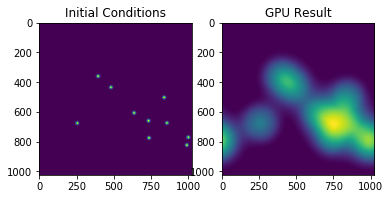

In [39]:
kernel_string = get_kernel_string(nx, ny, D = 0.0005, dt = 0.025, dx = 0.025)
# kernel_string = get_kernel_string(nx, ny)

field = ic.copy()

iterations = 10**4

#allocate GPU memory
u_old = drv.mem_alloc(field_copy.nbytes)
u_new = drv.mem_alloc(field_copy.nbytes)
#setup thread block dimensions and compile the kernel
diffuse_kernel = SourceModule(block_size_string+kernel_string).get_function("diffuse_kernel")
#create events for measuring performance
start = drv.Event()
end = drv.Event()
#move the data to the GPU
drv.memcpy_htod(u_old, field_copy)
drv.memcpy_htod(u_new, field_copy)
#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    diffuse_kernel(u_new, u_old, block=threads, grid=grid)
    diffuse_kernel(u_old, u_new, block=threads, grid=grid)
end.record()
context.synchronize()
print(f"{iterations*2} steps of diffuse took {end.time_since(start):.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result = np.zeros_like(field_copy)
drv.memcpy_dtoh(gpu_result, u_new)
fig, (ax1, ax2) = pyplot.subplots(1,2)

ax1.imshow(field_copy)
ax1.set_title("Initial Conditions")
ax2.imshow(gpu_result)
ax2.set_title("GPU Result")
plt.show()

In [6]:
1024/16

64.0

In [35]:
200000*0.025
print('5 seconds of simulation time simulated in 7.7 seconds of real time!')

5 seconds of simulation time simulated in 7.7 seconds of real time!


# diffusion with pbc on a pycuda kernel
- TODO: get the sim working on a 200x200 grid.
        - NB: note that width does not need to equal nx...
- TODO: get the sim working with my own defined initial conditions

In [1]:
#do the imports we need
import numpy as np
from matplotlib import pyplot
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import imshow, show
from timeit import default_timer as timer
import pycuda

import pycuda.driver as drv
from pycuda.compiler import SourceModule

#run drv.Device(0).make_context() only once.  if you run in ~30 times, you will get the following error
# MemoryError: cuCtxCreate failed: out of memory 
#initialize PyCuda and get compute capability needed for compilation
drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])


Error: cuInit failed: unknown error

In [20]:
#setup initial conditions
def get_initial_conditions(nx, ny):
    field = np.ones((ny, nx)).astype(np.float32)
    field[np.random.randint(0,nx,size=10), np.random.randint(0,ny,size=10)] = 1e3
    return field

def diffuse(field, dt=0.225):
    field[1:nx-1,1:ny-1] = field[1:nx-1,1:ny-1] + dt * (
        field[1:nx-1,2:ny]+field[2:nx,1:ny-1]-4*field[1:nx-1,1:ny-1]+
        field[0:nx-2,1:ny-1]+field[1:nx-1,0:ny-2] )
    return field

In [24]:
nx = 1024#200#1024
ny = 1024#200#1024
threads = (16,16,1)
grid = (int(nx/16), int(ny/16), 1)
block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"


# #save the ic field for later use
# Vin  = np.array([256*x*(y+1) for x in range(nx) for y in range(ny)]).reshape((nx,ny))
# field = Vin.copy()
ic = get_initial_conditions(nx, ny)
field = ic.copy()

field_copy = field.copy()
for q in range(100):
    field_copy = diffuse(field_copy)

In [36]:
def get_kernel_string(nx, ny, D, dt, dx):
    return f"""
#define nx {int(nx)}
#define ny {int(ny)}
#define width nx
#define height ny
#define dcoef {float(D*dt/dx**2)}

// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {{
    if (q >= wid) {{
        q = 1;
    }}
    if (q <= 0) {{
        q = wid-1;
    }}
     return q;
}}

// main kernel/face shader
__global__ void diffuse_kernel(float *u_new, float *u) {{
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
    if (x>=0 && x<nx && y>=0 && y<ny) {{
            int up    = _pbc(y+1,height);
            int down  = _pbc(y-1,height);
            int left  = _pbc(x-1, width);
            int right = _pbc(x+1, width);
            
            u_new[y*nx+x] = u[y*nx+x] + dcoef * (
            u[(up)*nx+x]+u[y*nx+right]
            -4.0f*u[y*nx+x]
            +u[y*nx+left]+u[(down)*nx+x]
            );
    }}
}}
    """   
#TODO: unallocate device memory
#     free(a_h); free(b_h); cudaFree(a_d); cudaFree(b_d)

200000 steps of diffuse took 7700 ms.


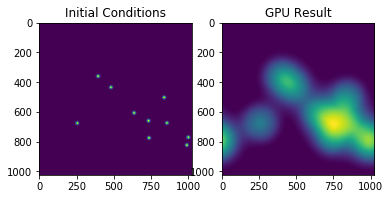

In [39]:
kernel_string = get_kernel_string(nx, ny, D = 0.0005, dt = 0.025, dx = 0.025)
# kernel_string = get_kernel_string(nx, ny)

field = ic.copy()

iterations = 10**4

#allocate GPU memory
u_old = drv.mem_alloc(field_copy.nbytes)
u_new = drv.mem_alloc(field_copy.nbytes)
#setup thread block dimensions and compile the kernel
diffuse_kernel = SourceModule(block_size_string+kernel_string).get_function("diffuse_kernel")
#create events for measuring performance
start = drv.Event()
end = drv.Event()
#move the data to the GPU
drv.memcpy_htod(u_old, field_copy)
drv.memcpy_htod(u_new, field_copy)
#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    diffuse_kernel(u_new, u_old, block=threads, grid=grid)
    diffuse_kernel(u_old, u_new, block=threads, grid=grid)
end.record()
context.synchronize()
print(f"{iterations*2} steps of diffuse took {end.time_since(start):.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result = np.zeros_like(field_copy)
drv.memcpy_dtoh(gpu_result, u_new)
fig, (ax1, ax2) = pyplot.subplots(1,2)

ax1.imshow(field_copy)
ax1.set_title("Initial Conditions")
ax2.imshow(gpu_result)
ax2.set_title("GPU Result")
plt.show()

In [6]:
1024/16

64.0

In [35]:
200000*0.025
print('5 seconds of simulation time simulated in 7.7 seconds of real time!')

5 seconds of simulation time simulated in 7.7 seconds of real time!


# diffusion with pbc on a pycuda kernel
- TODO: get the sim working on a 200x200 grid.
        - NB: note that width does not need to equal nx...
- TODO: get the sim working with my own defined initial conditions

In [19]:
#do the imports we need
import numpy as np
from matplotlib import pyplot
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import imshow, show
from timeit import default_timer as timer

import pycuda

import pycuda.driver as drv
from pycuda.compiler import SourceModule

#run this once.  if you run in ~30 times, you will get the following error
# MemoryError: cuCtxCreate failed: out of memory 
#initialize PyCuda and get compute capability needed for compilation
drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])


In [20]:
#setup initial conditions
def get_initial_conditions(nx, ny):
    field = np.ones((ny, nx)).astype(np.float32)
    field[np.random.randint(0,nx,size=10), np.random.randint(0,ny,size=10)] = 1e3
    return field

def diffuse(field, dt=0.225):
    field[1:nx-1,1:ny-1] = field[1:nx-1,1:ny-1] + dt * (
        field[1:nx-1,2:ny]+field[2:nx,1:ny-1]-4*field[1:nx-1,1:ny-1]+
        field[0:nx-2,1:ny-1]+field[1:nx-1,0:ny-2] )
    return field

In [24]:
nx = 1024#200#1024
ny = 1024#200#1024
threads = (16,16,1)
grid = (int(nx/16), int(ny/16), 1)
block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"


# #save the ic field for later use
# Vin  = np.array([256*x*(y+1) for x in range(nx) for y in range(ny)]).reshape((nx,ny))
# field = Vin.copy()
ic = get_initial_conditions(nx, ny)
field = ic.copy()

field_copy = field.copy()
for q in range(100):
    field_copy = diffuse(field_copy)

In [36]:
def get_kernel_string(nx, ny, D, dt, dx):
    return f"""
#define nx {int(nx)}
#define ny {int(ny)}
#define width nx
#define height ny
#define dcoef {float(D*dt/dx**2)}

// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {{
    if (q >= wid) {{
        q = 1;
    }}
    if (q <= 0) {{
        q = wid-1;
    }}
     return q;
}}

// main kernel/face shader
__global__ void diffuse_kernel(float *u_new, float *u) {{
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
    if (x>=0 && x<nx && y>=0 && y<ny) {{
            int up    = _pbc(y+1,height);
            int down  = _pbc(y-1,height);
            int left  = _pbc(x-1, width);
            int right = _pbc(x+1, width);
            
            u_new[y*nx+x] = u[y*nx+x] + dcoef * (
            u[(up)*nx+x]+u[y*nx+right]
            -4.0f*u[y*nx+x]
            +u[y*nx+left]+u[(down)*nx+x]
            );
    }}
}}
    """   
#TODO: unallocate device memory
#     free(a_h); free(b_h); cudaFree(a_d); cudaFree(b_d)

200000 steps of diffuse took 7700 ms.


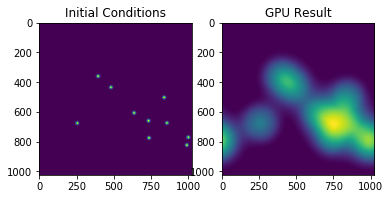

In [39]:
kernel_string = get_kernel_string(nx, ny, D = 0.0005, dt = 0.025, dx = 0.025)
# kernel_string = get_kernel_string(nx, ny)

field = ic.copy()

iterations = 10**4

#allocate GPU memory
u_old = drv.mem_alloc(field_copy.nbytes)
u_new = drv.mem_alloc(field_copy.nbytes)
#setup thread block dimensions and compile the kernel
diffuse_kernel = SourceModule(block_size_string+kernel_string).get_function("diffuse_kernel")
#create events for measuring performance
start = drv.Event()
end = drv.Event()
#move the data to the GPU
drv.memcpy_htod(u_old, field_copy)
drv.memcpy_htod(u_new, field_copy)
#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    diffuse_kernel(u_new, u_old, block=threads, grid=grid)
    diffuse_kernel(u_old, u_new, block=threads, grid=grid)
end.record()
context.synchronize()
print(f"{iterations*2} steps of diffuse took {end.time_since(start):.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result = np.zeros_like(field_copy)
drv.memcpy_dtoh(gpu_result, u_new)
fig, (ax1, ax2) = pyplot.subplots(1,2)

ax1.imshow(field_copy)
ax1.set_title("Initial Conditions")
ax2.imshow(gpu_result)
ax2.set_title("GPU Result")
plt.show()

In [6]:
1024/16

64.0

In [35]:
200000*0.025
print('5 seconds of simulation time simulated in 7.7 seconds of real time!')

5 seconds of simulation time simulated in 7.7 seconds of real time!


# diffusion with pbc on a pycuda kernel
- TODO: get the sim working on a 200x200 grid.
        - NB: note that width does not need to equal nx...
- TODO: get the sim working with my own defined initial conditions

In [19]:
#do the imports we need
import numpy as np
from matplotlib import pyplot
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import imshow, show
from timeit import default_timer as timer

import pycuda

import pycuda.driver as drv
from pycuda.compiler import SourceModule

#run this once.  if you run in ~30 times, you will get the following error
# MemoryError: cuCtxCreate failed: out of memory 
#initialize PyCuda and get compute capability needed for compilation
drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])


In [20]:
#setup initial conditions
def get_initial_conditions(nx, ny):
    field = np.ones((ny, nx)).astype(np.float32)
    field[np.random.randint(0,nx,size=10), np.random.randint(0,ny,size=10)] = 1e3
    return field

def diffuse(field, dt=0.225):
    field[1:nx-1,1:ny-1] = field[1:nx-1,1:ny-1] + dt * (
        field[1:nx-1,2:ny]+field[2:nx,1:ny-1]-4*field[1:nx-1,1:ny-1]+
        field[0:nx-2,1:ny-1]+field[1:nx-1,0:ny-2] )
    return field

In [24]:
nx = 1024#200#1024
ny = 1024#200#1024
threads = (16,16,1)
grid = (int(nx/16), int(ny/16), 1)
block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"


# #save the ic field for later use
# Vin  = np.array([256*x*(y+1) for x in range(nx) for y in range(ny)]).reshape((nx,ny))
# field = Vin.copy()
ic = get_initial_conditions(nx, ny)
field = ic.copy()

field_copy = field.copy()
for q in range(100):
    field_copy = diffuse(field_copy)

In [36]:
def get_kernel_string(nx, ny, D, dt, dx):
    return f"""
#define nx {int(nx)}
#define ny {int(ny)}
#define width nx
#define height ny
#define dcoef {float(D*dt/dx**2)}

// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {{
    if (q >= wid) {{
        q = 1;
    }}
    if (q <= 0) {{
        q = wid-1;
    }}
     return q;
}}

// main kernel/face shader
__global__ void diffuse_kernel(float *u_new, float *u) {{
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
    if (x>=0 && x<nx && y>=0 && y<ny) {{
            int up    = _pbc(y+1,height);
            int down  = _pbc(y-1,height);
            int left  = _pbc(x-1, width);
            int right = _pbc(x+1, width);
            
            u_new[y*nx+x] = u[y*nx+x] + dcoef * (
            u[(up)*nx+x]+u[y*nx+right]
            -4.0f*u[y*nx+x]
            +u[y*nx+left]+u[(down)*nx+x]
            );
    }}
}}
    """   
#TODO: unallocate device memory
#     free(a_h); free(b_h); cudaFree(a_d); cudaFree(b_d)

200000 steps of diffuse took 7700 ms.


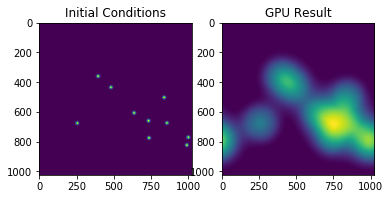

In [39]:
kernel_string = get_kernel_string(nx, ny, D = 0.0005, dt = 0.025, dx = 0.025)
# kernel_string = get_kernel_string(nx, ny)

field = ic.copy()

iterations = 10**4

#allocate GPU memory
u_old = drv.mem_alloc(field_copy.nbytes)
u_new = drv.mem_alloc(field_copy.nbytes)
#setup thread block dimensions and compile the kernel
diffuse_kernel = SourceModule(block_size_string+kernel_string).get_function("diffuse_kernel")
#create events for measuring performance
start = drv.Event()
end = drv.Event()
#move the data to the GPU
drv.memcpy_htod(u_old, field_copy)
drv.memcpy_htod(u_new, field_copy)
#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    diffuse_kernel(u_new, u_old, block=threads, grid=grid)
    diffuse_kernel(u_old, u_new, block=threads, grid=grid)
end.record()
context.synchronize()
print(f"{iterations*2} steps of diffuse took {end.time_since(start):.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result = np.zeros_like(field_copy)
drv.memcpy_dtoh(gpu_result, u_new)
fig, (ax1, ax2) = pyplot.subplots(1,2)

ax1.imshow(field_copy)
ax1.set_title("Initial Conditions")
ax2.imshow(gpu_result)
ax2.set_title("GPU Result")
plt.show()

In [6]:
1024/16

64.0

In [35]:
200000*0.025
print('5 seconds of simulation time simulated in 7.7 seconds of real time!')

5 seconds of simulation time simulated in 7.7 seconds of real time!


# diffusion with pbc on a pycuda kernel
- TODO: get the sim working on a 200x200 grid.
        - NB: note that width does not need to equal nx...
- TODO: get the sim working with my own defined initial conditions

In [19]:
#do the imports we need
import numpy as np
from matplotlib import pyplot
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import imshow, show
from timeit import default_timer as timer

import pycuda

import pycuda.driver as drv
from pycuda.compiler import SourceModule

#run this once.  if you run in ~30 times, you will get the following error
# MemoryError: cuCtxCreate failed: out of memory 
#initialize PyCuda and get compute capability needed for compilation
drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])


In [20]:
#setup initial conditions
def get_initial_conditions(nx, ny):
    field = np.ones((ny, nx)).astype(np.float32)
    field[np.random.randint(0,nx,size=10), np.random.randint(0,ny,size=10)] = 1e3
    return field

def diffuse(field, dt=0.225):
    field[1:nx-1,1:ny-1] = field[1:nx-1,1:ny-1] + dt * (
        field[1:nx-1,2:ny]+field[2:nx,1:ny-1]-4*field[1:nx-1,1:ny-1]+
        field[0:nx-2,1:ny-1]+field[1:nx-1,0:ny-2] )
    return field

In [24]:
nx = 1024#200#1024
ny = 1024#200#1024
threads = (16,16,1)
grid = (int(nx/16), int(ny/16), 1)
block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"


# #save the ic field for later use
# Vin  = np.array([256*x*(y+1) for x in range(nx) for y in range(ny)]).reshape((nx,ny))
# field = Vin.copy()
ic = get_initial_conditions(nx, ny)
field = ic.copy()

field_copy = field.copy()
for q in range(100):
    field_copy = diffuse(field_copy)

In [36]:
def get_kernel_string(nx, ny, D, dt, dx):
    return f"""
#define nx {int(nx)}
#define ny {int(ny)}
#define width nx
#define height ny
#define dcoef {float(D*dt/dx**2)}

// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {{
    if (q >= wid) {{
        q = 1;
    }}
    if (q <= 0) {{
        q = wid-1;
    }}
     return q;
}}

// main kernel/face shader
__global__ void diffuse_kernel(float *u_new, float *u) {{
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
    if (x>=0 && x<nx && y>=0 && y<ny) {{
            int up    = _pbc(y+1,height);
            int down  = _pbc(y-1,height);
            int left  = _pbc(x-1, width);
            int right = _pbc(x+1, width);
            
            u_new[y*nx+x] = u[y*nx+x] + dcoef * (
            u[(up)*nx+x]+u[y*nx+right]
            -4.0f*u[y*nx+x]
            +u[y*nx+left]+u[(down)*nx+x]
            );
    }}
}}
    """   
#TODO: unallocate device memory
#     free(a_h); free(b_h); cudaFree(a_d); cudaFree(b_d)

200000 steps of diffuse took 7700 ms.


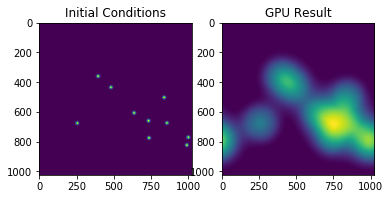

In [39]:
kernel_string = get_kernel_string(nx, ny, D = 0.0005, dt = 0.025, dx = 0.025)
# kernel_string = get_kernel_string(nx, ny)

field = ic.copy()

iterations = 10**4

#allocate GPU memory
u_old = drv.mem_alloc(field_copy.nbytes)
u_new = drv.mem_alloc(field_copy.nbytes)
#setup thread block dimensions and compile the kernel
diffuse_kernel = SourceModule(block_size_string+kernel_string).get_function("diffuse_kernel")
#create events for measuring performance
start = drv.Event()
end = drv.Event()
#move the data to the GPU
drv.memcpy_htod(u_old, field_copy)
drv.memcpy_htod(u_new, field_copy)
#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    diffuse_kernel(u_new, u_old, block=threads, grid=grid)
    diffuse_kernel(u_old, u_new, block=threads, grid=grid)
end.record()
context.synchronize()
print(f"{iterations*2} steps of diffuse took {end.time_since(start):.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result = np.zeros_like(field_copy)
drv.memcpy_dtoh(gpu_result, u_new)
fig, (ax1, ax2) = pyplot.subplots(1,2)

ax1.imshow(field_copy)
ax1.set_title("Initial Conditions")
ax2.imshow(gpu_result)
ax2.set_title("GPU Result")
plt.show()

In [6]:
1024/16

64.0

In [35]:
200000*0.025
print('5 seconds of simulation time simulated in 7.7 seconds of real time!')

5 seconds of simulation time simulated in 7.7 seconds of real time!
